# Hors thème : Clustering spatial
- Clustering spatial par catégories
- Transformer les cluster en surfaciques

## Python stuff

In [ ]:
import math
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from s3_utils import S3Manager

# Configs
_ = plt.style.use("ggplot")

## 1 - Récupération et préparation des données

In [2]:
# Chargement des éléments de connexion sur S3
s3_manager = S3Manager()
bucket = "fub-s3"

In [3]:
# Déjà executé
# s3_manager.download_from_s3(
#     bucket,
#     "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson", 
#     "temp/données-carto-2025-06-03.geojson"
# )

In [4]:
# Données données internes
# gdf = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson")
gdf = gpd.read_file("temp/données-carto-2025-06-03.geojson")

In [5]:
# Récupération par communes
communes = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/communes.geojson")
communes = communes.to_crs(4326)

In [6]:
gdf = gdf.to_crs(communes.crs)
gdf_filtre = gpd.sjoin(gdf, communes, predicate="within", how="inner")
gdf_filtre = gdf_filtre.drop(columns=["index_right"])
gdf_filtre.rename(columns={"code": "code_commune", "nom": "nom_commune"}, inplace=True)

## 2 - Clustering spatial

### 2.1 - Contexte : Description des catégories en fonction du formulaire
Type de réponse : Geoloc + Commentaire

- Cat 60 : Cliquez sur la carte pour indiquer les 3 endroits où les conditions de circulation à vélo se sont le plus améliorées sur les deux dernières années.

- Cat 59 : Cliquez sur la carte pour indiquer les 3 endroits où le besoin en emplacements de stationnement sécurisé vous paraît le plus important.

- Cat 58 : Cliquez sur la carte pour indiquer les 3 endroits les plus problématiques pour se déplacer à vélo.

In [7]:
# Fonction de clustering
def dbscan_clustering(gdf: gpd.GeoDataFrame, dist_m=50):
    """
    Effectue un clustering spatial sur un GeoDataFrame.
    
    :param gdf: GeoDataFrame avec des géométries de points.
    :param dist_m : Distance en mètre entre les points pour former un cluster.
    :return: GeoDataFrame avec les clusters ajoutés.
    """
    # Step --> Reprojection
    gdf = gdf.to_crs(epsg=2154)
    print(f"✅ La projection du GeoDataFrame est : {gdf.crs}")

    # Step calcul log(n)
    min_sample = round(math.log(gdf.shape[0])) + 1
    print(f"ℹ️ La taille de l'échantillon est : {gdf.shape[0]}")
    print(f"ℹ️ Le nombre minimal d'échantillons pour le clustering est : {min_sample}")

    # Appliquer le clustering
    dbscan = DBSCAN(eps=dist_m, min_samples=min_sample, metric='euclidean')
    dbscan.fit(gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())
    gdf["cluster_id"] = dbscan.labels_
    gdf = gdf[gdf["cluster_id"] != -1] # elimine le bruit

    print(f"ℹ️ Le nombre de clusters formés est : {gdf['cluster_id'].nunique()}")

    return gdf

### 2.2 - Cat 58

In [8]:
gdf_58 = gdf_filtre[gdf_filtre["cat"] == 58].copy()

In [9]:
gdf_58_cluster =  dbscan_clustering(gdf_58, dist_m=50)

✅ La projection du GeoDataFrame est : EPSG:2154
ℹ️ La taille de l'échantillon est : 578129
ℹ️ Le nombre minimal d'échantillons pour le clustering est : 14
ℹ️ Le nombre de clusters formés est : 2554


In [10]:
gdf_58_cluster.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id
11,261dbaa4-2555-40b2-a627-cb7c0d947172,58,d9bfec3d-fef7-47c9-b949-60964467556f,,POINT (649408.469 6857573.511),92049,Montrouge,0
12,8489e10a-8434-4d03-8161-a0606c67f44b,58,d9bfec3d-fef7-47c9-b949-60964467556f,,POINT (650046.279 6857826.091),92049,Montrouge,1
13,ed3526e8-b6be-4da9-9d41-0ecb06c3a5e9,58,d9bfec3d-fef7-47c9-b949-60964467556f,None,POINT (649583.93 6858198.984),92046,Malakoff,117
20,8f6e0b77-2819-435e-a910-ceb2905e89ae,58,edf78d17-34e7-4c6a-879b-a3f298e67105,Grand échangeur,POINT (844277.987 6514733.276),69199,Saint-Fons,2
36,5bfb4b03-40ea-46b3-94ee-8673d60c7476,58,dd6f4d6b-d8e2-481b-8bd4-b7250cdd8020,Le quai entre la poste et la gare,POINT (691142.386 6873142.459),77284,Meaux,3


### 2.2 - Cat 59

In [11]:
gdf_59 = gdf_filtre[gdf_filtre["cat"] == 59].copy()

In [12]:
gdf_59_cluster =  dbscan_clustering(gdf_59, dist_m=50)

✅ La projection du GeoDataFrame est : EPSG:2154
ℹ️ La taille de l'échantillon est : 289602
ℹ️ Le nombre minimal d'échantillons pour le clustering est : 14
ℹ️ Le nombre de clusters formés est : 1344


In [13]:
gdf_59_cluster.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id
21,3a0f72f0-9f76-4cb1-bad8-488704138b63,59,edf78d17-34e7-4c6a-879b-a3f298e67105,Vl1,POINT (843074.002 6519188.159),69383,Lyon 3e Arrondissement,272
82,acacff84-3a1b-41ec-8505-5a4a7da18375,59,851f200d-9469-4ca9-bd9f-2436600cb37d,None,POINT (604305.168 6306725.084),81145,Lisle-sur-Tarn,0
95,6dc3b455-df8c-43ef-87fc-2f31d4db92f9,59,4ef4a45c-43bd-4f00-baa9-bc925a7fed74,"place du marché le samedi , bibliothèque et ét...",POINT (769495.05 6438619.213),43157,Puy-en-Velay,1
102,ba879e46-8f10-4624-8654-dc7f3b948577,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049878.184 6841974.255),67482,Strasbourg,2
103,f5cb1917-8625-468f-84de-52d5caf7c4b4,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049014.158 6842047.776),67482,Strasbourg,3


### 2.3 - Cat 60

In [14]:
gdf_60 = gdf_filtre[gdf_filtre["cat"] == 60].copy()

In [15]:
gdf_60_cluster =  dbscan_clustering(gdf_60, dist_m=50)

✅ La projection du GeoDataFrame est : EPSG:2154
ℹ️ La taille de l'échantillon est : 239552
ℹ️ Le nombre minimal d'échantillons pour le clustering est : 13
ℹ️ Le nombre de clusters formés est : 930


In [16]:
gdf_60_cluster.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id
131,693d9f67-82db-483a-95b4-10f448054d2b,60,3e99dd98-1874-48b3-8a2e-e11626d9231d,None,POINT (568535.323 6324505.89),82121,Montauban,0
162,1e085e3a-8c4f-4daa-af4b-c43bc0e4d7d3,60,0bbb7ebf-bd6b-407c-a26f-d5799fd7c083,Boulevard de l'europe,POINT (560912.975 6927000.277),76540,Rouen,1
241,6d9e0332-000a-4ffa-8f7b-8e37c4eb0f29,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,POINT (704692.585 7058695.117),59350,Lille,2
242,7ad1ece0-1490-4bfe-b721-e608c53fc3dd,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,POINT (704862.626 7059170.019),59350,Lille,3
243,118d33ef-cc7c-4c3c-a9c3-a0b9428fed87,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,"Très bon travail de séparation, attention aux ...",POINT (704640.605 7059602.651),59350,Lille,4


## 3 - Classement par nombre de points par clusters

### 3.1 - Aggregation des clusters

In [17]:
# Compte des points par cluster
cluster_counts_58 = (
    gdf_58_cluster
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)
cluster_counts_58.sort_values(by="nb_points", ascending=False).head(3)

,cluster_id,nb_points
51,51,1638
195,195,1509
201,201,992


In [18]:
# Compte des points par cluster 
cluster_counts_59 = (
    gdf_59_cluster
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)
cluster_counts_59.sort_values(by="nb_points", ascending=False).head(3)

,cluster_id,nb_points
12,12,983
97,97,875
40,40,760


In [19]:
# Compte des points par cluster 
cluster_counts_60 = (
    gdf_60_cluster
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)
cluster_counts_60.sort_values(by="nb_points", ascending=False).head(3)

,cluster_id,nb_points
57,57,2509
43,43,1273
110,110,831


### 3.2 - Jointure pour affichage

In [20]:
gdf_58_cluster_nb = gdf_58_cluster.merge(cluster_counts_58, on="cluster_id")
gdf_58_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points
0,261dbaa4-2555-40b2-a627-cb7c0d947172,58,d9bfec3d-fef7-47c9-b949-60964467556f,,POINT (649408.469 6857573.511),92049,Montrouge,0,89
1,8489e10a-8434-4d03-8161-a0606c67f44b,58,d9bfec3d-fef7-47c9-b949-60964467556f,,POINT (650046.279 6857826.091),92049,Montrouge,1,109
2,ed3526e8-b6be-4da9-9d41-0ecb06c3a5e9,58,d9bfec3d-fef7-47c9-b949-60964467556f,None,POINT (649583.93 6858198.984),92046,Malakoff,117,73
3,8f6e0b77-2819-435e-a910-ceb2905e89ae,58,edf78d17-34e7-4c6a-879b-a3f298e67105,Grand échangeur,POINT (844277.987 6514733.276),69199,Saint-Fons,2,24
4,5bfb4b03-40ea-46b3-94ee-8673d60c7476,58,dd6f4d6b-d8e2-481b-8bd4-b7250cdd8020,Le quai entre la poste et la gare,POINT (691142.386 6873142.459),77284,Meaux,3,33


In [21]:
gdf_59_cluster_nb = gdf_59_cluster.merge(cluster_counts_59, on="cluster_id")
gdf_59_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points
0,3a0f72f0-9f76-4cb1-bad8-488704138b63,59,edf78d17-34e7-4c6a-879b-a3f298e67105,Vl1,POINT (843074.002 6519188.159),69383,Lyon 3e Arrondissement,272,64
1,acacff84-3a1b-41ec-8505-5a4a7da18375,59,851f200d-9469-4ca9-bd9f-2436600cb37d,None,POINT (604305.168 6306725.084),81145,Lisle-sur-Tarn,0,17
2,6dc3b455-df8c-43ef-87fc-2f31d4db92f9,59,4ef4a45c-43bd-4f00-baa9-bc925a7fed74,"place du marché le samedi , bibliothèque et ét...",POINT (769495.05 6438619.213),43157,Puy-en-Velay,1,54
3,ba879e46-8f10-4624-8654-dc7f3b948577,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049878.184 6841974.255),67482,Strasbourg,2,487
4,f5cb1917-8625-468f-84de-52d5caf7c4b4,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049014.158 6842047.776),67482,Strasbourg,3,340


In [22]:
gdf_60_cluster_nb = gdf_60_cluster.merge(cluster_counts_60, on="cluster_id")
gdf_60_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points
0,693d9f67-82db-483a-95b4-10f448054d2b,60,3e99dd98-1874-48b3-8a2e-e11626d9231d,None,POINT (568535.323 6324505.89),82121,Montauban,0,47
1,1e085e3a-8c4f-4daa-af4b-c43bc0e4d7d3,60,0bbb7ebf-bd6b-407c-a26f-d5799fd7c083,Boulevard de l'europe,POINT (560912.975 6927000.277),76540,Rouen,1,148
2,6d9e0332-000a-4ffa-8f7b-8e37c4eb0f29,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,POINT (704692.585 7058695.117),59350,Lille,2,326
3,7ad1ece0-1490-4bfe-b721-e608c53fc3dd,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,POINT (704862.626 7059170.019),59350,Lille,3,148
4,118d33ef-cc7c-4c3c-a9c3-a0b9428fed87,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,"Très bon travail de séparation, attention aux ...",POINT (704640.605 7059602.651),59350,Lille,4,555


### 3.3 - Jointure score par taux de participation

#### 3.3.1 - Cluster 58

In [23]:
# Compter les points par communes
cluster_taux_58 = (
    gdf_58_cluster_nb
    .groupby("nom_commune")
    .size()
    .reset_index(name="total_commune")
)
cluster_taux_58.sort_values(by="total_commune", ascending=False).head(3)

,nom_commune,total_commune
665,Toulouse,3799
430,Nantes,3443
289,Grenoble,2761


In [24]:
gdf_58_cluster_nb = gdf_58_cluster_nb.merge(cluster_taux_58, on="nom_commune")
gdf_58_cluster_nb["taux_points"] =  round((gdf_58_cluster_nb["nb_points"] / gdf_58_cluster_nb["total_commune"]) * 100, 2)
gdf_58_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points,total_commune,taux_points
0,261dbaa4-2555-40b2-a627-cb7c0d947172,58,d9bfec3d-fef7-47c9-b949-60964467556f,,POINT (649408.469 6857573.511),92049,Montrouge,0,89,554,16.06
1,8489e10a-8434-4d03-8161-a0606c67f44b,58,d9bfec3d-fef7-47c9-b949-60964467556f,,POINT (650046.279 6857826.091),92049,Montrouge,1,109,554,19.68
2,ed3526e8-b6be-4da9-9d41-0ecb06c3a5e9,58,d9bfec3d-fef7-47c9-b949-60964467556f,None,POINT (649583.93 6858198.984),92046,Malakoff,117,73,486,15.02
3,8f6e0b77-2819-435e-a910-ceb2905e89ae,58,edf78d17-34e7-4c6a-879b-a3f298e67105,Grand échangeur,POINT (844277.987 6514733.276),69199,Saint-Fons,2,24,37,64.86
4,5bfb4b03-40ea-46b3-94ee-8673d60c7476,58,dd6f4d6b-d8e2-481b-8bd4-b7250cdd8020,Le quai entre la poste et la gare,POINT (691142.386 6873142.459),77284,Meaux,3,33,160,20.62


#### 3.3.2 - Cluster 59 

In [25]:
# Compter les points par communes
cluster_taux_59 = (
    gdf_59_cluster_nb
    .groupby("nom_commune")
    .size()
    .reset_index(name="total_commune")
)
cluster_taux_59.sort_values(by="total_commune", ascending=False).head(3)

,nom_commune,total_commune
320,Montpellier,2202
531,Toulouse,1945
211,Grenoble,1686


In [26]:
gdf_59_cluster_nb = gdf_59_cluster_nb.merge(cluster_taux_59, on="nom_commune")
gdf_59_cluster_nb["taux_points"] =  round((gdf_59_cluster_nb["nb_points"] / gdf_59_cluster_nb["total_commune"]) * 100, 2)
gdf_59_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points,total_commune,taux_points
0,3a0f72f0-9f76-4cb1-bad8-488704138b63,59,edf78d17-34e7-4c6a-879b-a3f298e67105,Vl1,POINT (843074.002 6519188.159),69383,Lyon 3e Arrondissement,272,64,925,6.92
1,acacff84-3a1b-41ec-8505-5a4a7da18375,59,851f200d-9469-4ca9-bd9f-2436600cb37d,None,POINT (604305.168 6306725.084),81145,Lisle-sur-Tarn,0,17,17,100.00
2,6dc3b455-df8c-43ef-87fc-2f31d4db92f9,59,4ef4a45c-43bd-4f00-baa9-bc925a7fed74,"place du marché le samedi , bibliothèque et ét...",POINT (769495.05 6438619.213),43157,Puy-en-Velay,1,54,100,54.00
3,ba879e46-8f10-4624-8654-dc7f3b948577,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049878.184 6841974.255),67482,Strasbourg,2,487,1021,47.70
4,f5cb1917-8625-468f-84de-52d5caf7c4b4,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049014.158 6842047.776),67482,Strasbourg,3,340,1021,33.30


#### 3.3.3 - Cluster 60

In [27]:
# Compter les points par communes
cluster_taux_60 = (
    gdf_60_cluster_nb
    .groupby("nom_commune")
    .size()
    .reset_index(name="total_commune")
)
cluster_taux_60.sort_values(by="total_commune", ascending=False).head(3)

,nom_commune,total_commune
313,Toulouse,3151
151,Lyon 3e Arrondissement,1867
183,Montpellier,1848


In [28]:
gdf_60_cluster_nb = gdf_60_cluster_nb.merge(cluster_taux_60, on="nom_commune")
gdf_60_cluster_nb["taux_points"] =  round((gdf_60_cluster_nb["nb_points"] / gdf_60_cluster_nb["total_commune"]) * 100, 2)
gdf_60_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points,total_commune,taux_points
0,693d9f67-82db-483a-95b4-10f448054d2b,60,3e99dd98-1874-48b3-8a2e-e11626d9231d,None,POINT (568535.323 6324505.89),82121,Montauban,0,47,115,40.87
1,1e085e3a-8c4f-4daa-af4b-c43bc0e4d7d3,60,0bbb7ebf-bd6b-407c-a26f-d5799fd7c083,Boulevard de l'europe,POINT (560912.975 6927000.277),76540,Rouen,1,148,421,35.15
2,6d9e0332-000a-4ffa-8f7b-8e37c4eb0f29,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,POINT (704692.585 7058695.117),59350,Lille,2,326,1619,20.14
3,7ad1ece0-1490-4bfe-b721-e608c53fc3dd,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,POINT (704862.626 7059170.019),59350,Lille,3,148,1619,9.14
4,118d33ef-cc7c-4c3c-a9c3-a0b9428fed87,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,"Très bon travail de séparation, attention aux ...",POINT (704640.605 7059602.651),59350,Lille,4,555,1619,34.28


### 3.4 - Enveloppe convexe 
> Passage des données en points vers des données surfacique

#### 3.4.1 - Cluster 58

In [29]:
# Groupement par cluster
gdf_58_cluster_surf = gdf_58_cluster_nb.groupby('cluster_id')

# Créaction de l'enveloppe convex
polygons_58 = gdf_58_cluster_surf.geometry.apply(lambda x: x.union_all().convex_hull)
gdf_polygons_58 = gpd.GeoDataFrame(polygons_58, geometry=polygons_58, crs=gdf_58_cluster_nb.crs).reset_index()
gdf_polygons_58.head()

,cluster_id,geometry
0,0,"POLYGON ((649417.452 6857501.995, 649410.088 6..."
1,1,"POLYGON ((650006.186 6857724.862, 649960.321 6..."
2,2,"POLYGON ((844290.747 6514691.452, 844263.399 6..."
3,3,"POLYGON ((691055.147 6873095.487, 691036.354 6..."
4,4,"POLYGON ((570726.695 6282206.306, 570700.212 6..."


In [30]:
gdf_58_cluster_s = gdf_polygons_58.merge(gdf_58_cluster_nb, on='cluster_id', how='left', suffixes=('', '_point'))
gdf_58_cluster_s[gdf_58_cluster_s["geometry_point"].notna()]
gdf_58_cluster_s.drop(columns='geometry_point', inplace=True)
gdf_58_cluster_s = gdf_58_cluster_s.drop_duplicates("cluster_id")
print(gdf_58_cluster_s.shape)
gdf_58_cluster_s.head()

(2554, 11)


,cluster_id,geometry,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points
0,0,"POLYGON ((649417.452 6857501.995, 649410.088 6...",261dbaa4-2555-40b2-a627-cb7c0d947172,58,d9bfec3d-fef7-47c9-b949-60964467556f,,92049,Montrouge,89,554,16.06
89,1,"POLYGON ((650006.186 6857724.862, 649960.321 6...",8489e10a-8434-4d03-8161-a0606c67f44b,58,d9bfec3d-fef7-47c9-b949-60964467556f,,92049,Montrouge,109,554,19.68
198,2,"POLYGON ((844290.747 6514691.452, 844263.399 6...",8f6e0b77-2819-435e-a910-ceb2905e89ae,58,edf78d17-34e7-4c6a-879b-a3f298e67105,Grand échangeur,69199,Saint-Fons,24,37,64.86
222,3,"POLYGON ((691055.147 6873095.487, 691036.354 6...",5bfb4b03-40ea-46b3-94ee-8673d60c7476,58,dd6f4d6b-d8e2-481b-8bd4-b7250cdd8020,Le quai entre la poste et la gare,77284,Meaux,33,160,20.62
255,4,"POLYGON ((570726.695 6282206.306, 570700.212 6...",b6cf0db2-c5d6-420d-85c5-eb4a8e191262,58,ac133ff0-2ab5-4726-8710-99623a867c25,Pas de piste cyclable,31069,Blagnac,43,195,22.05


#### 3.4.2 - Cluster 59 

In [31]:
# Groupement par cluster
gdf_59_cluster_surf = gdf_59_cluster_nb.groupby('cluster_id')

# Créaction de l'enveloppe convex
polygons_59 = gdf_59_cluster_surf.geometry.apply(lambda x: x.union_all().convex_hull)
gdf_polygons_59 = gpd.GeoDataFrame(polygons_59, geometry=polygons_59, crs=gdf_59_cluster_nb.crs).reset_index()
gdf_polygons_59.head()

,cluster_id,geometry
0,0,"POLYGON ((604338.447 6306703.38, 604306.332 63..."
1,1,"POLYGON ((769595.59 6438525.93, 769482.947 643..."
2,2,"POLYGON ((1050047.86 6841714.68, 1049823.841 6..."
3,3,"POLYGON ((1048984.044 6841974.855, 1048972.629..."
4,4,"POLYGON ((841055.865 6579807.368, 841003.577 6..."


In [32]:
gdf_59_cluster_s = gdf_polygons_59.merge(gdf_59_cluster_nb, on='cluster_id', how='left', suffixes=('', '_point'))
gdf_59_cluster_s[gdf_59_cluster_s["geometry_point"].notna()]
gdf_59_cluster_s.drop(columns='geometry_point', inplace=True)
gdf_59_cluster_s = gdf_59_cluster_s.drop_duplicates("cluster_id")
print(gdf_59_cluster_s.shape)
gdf_59_cluster_s.head()

(1344, 11)


,cluster_id,geometry,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points
0,0,"POLYGON ((604338.447 6306703.38, 604306.332 63...",acacff84-3a1b-41ec-8505-5a4a7da18375,59,851f200d-9469-4ca9-bd9f-2436600cb37d,None,81145,Lisle-sur-Tarn,17,17,100.00
17,1,"POLYGON ((769595.59 6438525.93, 769482.947 643...",6dc3b455-df8c-43ef-87fc-2f31d4db92f9,59,4ef4a45c-43bd-4f00-baa9-bc925a7fed74,"place du marché le samedi , bibliothèque et ét...",43157,Puy-en-Velay,54,100,54.00
71,2,"POLYGON ((1050047.86 6841714.68, 1049823.841 6...",ba879e46-8f10-4624-8654-dc7f3b948577,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,67482,Strasbourg,487,1021,47.70
558,3,"POLYGON ((1048984.044 6841974.855, 1048972.629...",f5cb1917-8625-468f-84de-52d5caf7c4b4,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,67482,Strasbourg,340,1021,33.30
898,4,"POLYGON ((841055.865 6579807.368, 841003.577 6...",5ab66b17-d248-4c0c-8fc0-ec3386aaddb0,59,dd166c12-62ef-4d16-b745-77c88de03542,+ d'emplacements au niveau de la place saint p...,71270,Mâcon,15,83,18.07


#### 3.4.3 - Cluster 60

In [33]:
# Groupement par cluster
gdf_60_cluster_surf = gdf_60_cluster_nb.groupby('cluster_id')

# Créaction de l'enveloppe convex
polygons_60 = gdf_60_cluster_surf.geometry.apply(lambda x: x.union_all().convex_hull)
gdf_polygons_60 = gpd.GeoDataFrame(polygons_60, geometry=polygons_60, crs=gdf_60_cluster_nb.crs).reset_index()
gdf_polygons_60.head()

,cluster_id,geometry
0,0,"POLYGON ((568588.541 6324381.286, 568520.729 6..."
1,1,"POLYGON ((561129.919 6926874.117, 561054.041 6..."
2,2,"POLYGON ((704817.818 7058600.879, 704615.618 7..."
3,3,"POLYGON ((704840.925 7059011.862, 704828.113 7..."
4,4,"POLYGON ((704384.748 7059399.411, 704371.71 70..."


In [34]:
gdf_60_cluster_s = gdf_polygons_60.merge(gdf_60_cluster_nb, on='cluster_id', how='left', suffixes=('', '_point'))
gdf_60_cluster_s[gdf_60_cluster_s["geometry_point"].notna()]
gdf_60_cluster_s.drop(columns='geometry_point', inplace=True)
gdf_60_cluster_s = gdf_60_cluster_s.drop_duplicates("cluster_id")
print(gdf_60_cluster_s.shape)
gdf_60_cluster_s.head()

(930, 11)


,cluster_id,geometry,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points
0,0,"POLYGON ((568588.541 6324381.286, 568520.729 6...",693d9f67-82db-483a-95b4-10f448054d2b,60,3e99dd98-1874-48b3-8a2e-e11626d9231d,None,82121,Montauban,47,115,40.87
47,1,"POLYGON ((561129.919 6926874.117, 561054.041 6...",1e085e3a-8c4f-4daa-af4b-c43bc0e4d7d3,60,0bbb7ebf-bd6b-407c-a26f-d5799fd7c083,Boulevard de l'europe,76540,Rouen,148,421,35.15
195,2,"POLYGON ((704817.818 7058600.879, 704615.618 7...",6d9e0332-000a-4ffa-8f7b-8e37c4eb0f29,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,59350,Lille,326,1619,20.14
521,3,"POLYGON ((704840.925 7059011.862, 704828.113 7...",7ad1ece0-1490-4bfe-b721-e608c53fc3dd,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,Très bon travail de séparation,59350,Lille,148,1619,9.14
669,4,"POLYGON ((704384.748 7059399.411, 704371.71 70...",118d33ef-cc7c-4c3c-a9c3-a0b9428fed87,60,c3aed00b-2754-46a3-b26b-a5fb4c56b066,"Très bon travail de séparation, attention aux ...",59350,Lille,555,1619,34.28


## 4 - Visualisation d'un des clusters

In [35]:
viz_data_60 = gdf_60_cluster_s[gdf_60_cluster_s["nom_commune"].str.contains('Paris')]

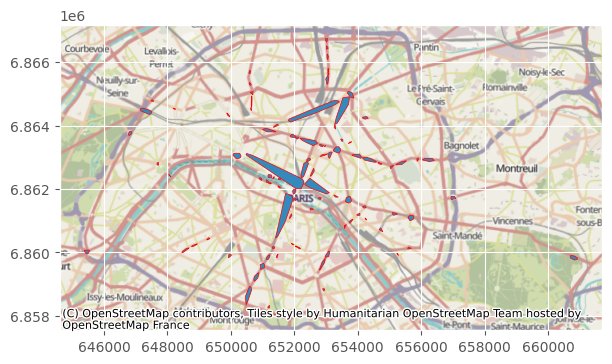

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))
viz_data_60.plot(ax=ax, alpha=1, edgecolor='red')
_ = ctx.add_basemap(ax, crs=viz_data_60.crs.to_string())
plt.show()

## 5 - Export des données

In [37]:
gdf_58_cluster_s_export = gdf_58_cluster_s.to_crs(epsg=4326).copy()
gdf_59_cluster_s_export = gdf_59_cluster_s.to_crs(epsg=4326).copy()
gdf_60_cluster_s_export = gdf_60_cluster_s.to_crs(epsg=4326).copy()

In [38]:
print("CRS gdf_58_cluster_nb:", gdf_58_cluster_s_export.crs)
print("CRS gdf_59_cluster_nb:", gdf_59_cluster_s_export.crs)
print("CRS gdf_60_cluster_nb:", gdf_60_cluster_s_export.crs)

CRS gdf_58_cluster_nb: EPSG:4326
CRS gdf_59_cluster_nb: EPSG:4326
CRS gdf_60_cluster_nb: EPSG:4326


In [39]:
gdf_58_cluster_s_export.to_file("temp/cluster_cat_58.geojson", driver="GeoJSON")
gdf_59_cluster_s_export.to_file("temp/cluster_cat_59.geojson", driver="GeoJSON")
gdf_60_cluster_s_export.to_file("temp/cluster_cat_60.geojson", driver="GeoJSON")

-- END --